<a href="https://colab.research.google.com/github/Clinda02/text_data_analysis/blob/main/NLP/naver_movie_sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

* 데이터 출처 : https://github.com/e9t/nsmc/
* `label` : positve(1), negative(0)

In [ ]:
import pandas as pd

# 데이터가 저장되어있는 repository에서 곧장 불러옴, 구분자(tab)
df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/refs/heads/master/ratings_train.txt',sep = '\t')
# csv 파일 구분자 : ,(콤마)
# txt 파일 구분자 : \t(탭)

df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# EDA

In [ ]:
# shape
df.shape

(150000, 3)

shape을 확인한 결과, train 데이터는 150,000개의 인스턴스와 3개의 컬럼으로 구성되어 있음

In [ ]:
# null 데이터
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


,0
id,0
document,5
label,0


불러온 데이터에 결측치가 포함되어 있는지 여부를 확인한 결과, `document` 칼럼에 5개의 결측치가 포함되어 있음을 확인함.


In [ ]:
# document 칼럼에 null이 포함되어 있는 경우만 추출
df[df['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


결측치가 포함된 칼럼의 `label`은 1(positive)가 2개, 0(negative)가 3개로 각 카테고리에 거의 비슷한 분포로 결측치가 포함되어 있음.





In [ ]:
#결측치 제거
df.dropna(inplace = True)

전체 데이터 양에 비해 결측치가 차지하는 비중이 낮으므로, 결측치를 삭제하고, 데이터 분석을 진행하고자 함.

In [ ]:
df.shape

(149995, 3)

결측치 처리 결과, 149,995개의 인스턴스가 최종적으로 남아있음을 확인할 수 있음.

In [ ]:
#label 분포
df['label'].value_counts()

,count
label,
0,75170
1,74825


train 데이터 셋에 대해서 label의 분포를 확인한 결과, 0(negative)는 75,170개, 1(positive)는 74,825개로 거의 비슷한 비율로 분포되어 있음.

In [ ]:
#텍스트 길이
df['len'] = df['document'].str.len()

print(df['len'].mean())
df.head()

35.204526817560584


,id,document,label,len
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33
2,10265843,너무재밓었다그래서보는것을추천한다,0,17
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61


<Axes: xlabel='len', ylabel='Count'>

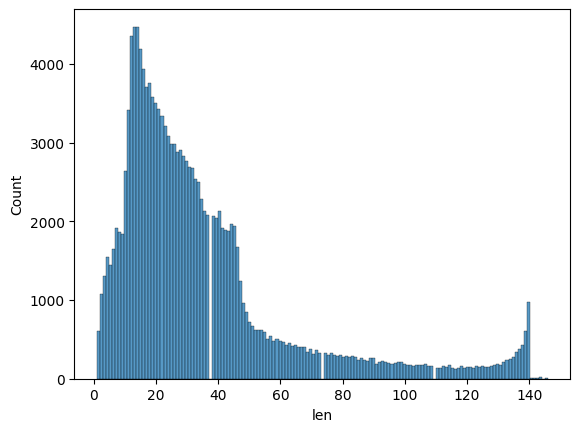

In [ ]:
# 텍스트 길이 시각화
import seaborn as sns

sns.histplot(df['len'])

일반적으로 사용자는 **20 ~ 30자** 글자 사이의 댓글을 가장 많이 다는 것을 알 수 있었다. 추후 신경망을 사용하여 학습하기 위해, 글자수를 특정값 기준으로 잘라줘야 할 경우, **`60 글자`** 정도 수준에서 분할하여 처리할 예정이다.

# 워드 클라우드
- 긍정/부정 후기에 따른 빈도수 top 50 명사의 워드클라우드 시각화

In [ ]:
# 워드 클라우드
import matplotlib.pyplot as plt
from wordcloud import WordCloud

!apt-get install -y fonts-nanum
import matplotlib.font_manager as fm

# 나눔 고딕 폰트를 사용하도록 폰트 경로 지정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


### 단계 1: 문자열 데이터 추출
* 긍정과 부정 키워드에 대해 각각 워드클라우드를 생성하고자 함
* `document`컬럼에 담긴 데이터를 긍정과 부정으로 나누어서 별도의 변수(`positive_text`, `negative_text`)에 할당

In [ ]:
# label을 통해 긍정/부정 코멘트 분리
# positive
positive_text = df[df['label']== 1]['document']
positive_text.head()

# negative
negative_text = df[df['label']== 0]['document']
negative_text.head()

,document
0,아 더빙.. 진짜 짜증나네요 목소리
2,너무재밓었다그래서보는것을추천한다
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
6,원작의 긴장감을 제대로 살려내지못했다.


In [ ]:
# DataFrame 구조의 문자를 문자열 형태로 변환
negative_text = ' '.join(negative_text.astype(str))
positive_text = ' '.join(positive_text.astype(str))

**`.astype(str)`**의 역할
- positive_text = ' '.join(positive_text)             
   : document 연결 시 공백 분리 X,  숫자, NaN값 혹은 다른 타입의 값이 포함된 경우, **TypeError** 발생 가능.
- positive_text = ' '.join(positive_text.astype(str))
  
  : document 연결 시 공백 분리 , 숫자 및 NaN 모두 문자열로 인식.

### 단계 2 : 명사 추출(토큰화)

In [ ]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 31.0 MB/s eta 0:00:00


주어진 문장에서 명사만 추출하여 토큰화하고, 명사의 빈도수에 기초하여 워드클라우드를 생성하고자 함.


In [ ]:
from konlpy.tag import Okt
okt = Okt()

# 각 문자열에서 명사만 추출
negative_nouns = okt.nouns(negative_text)
positive_nouns = okt.nouns(positive_text)

### 단계 3 : 각 명사별 빈도수 확인
-  Counter 사용
  - 특정 단어가 몇 번 등장했는지 딕셔너리 타입으로 반환 (예: {"영화", 50})

In [ ]:
# 추출한 명사에서 각 명사가 몇 번 등장했는지 확인
from collections import Counter # 특정 단어가 몇 번 등장했는지 딕셔너리 타입으로 반환 (예: {"key", 50})
negative_counts = Counter(negative_nouns)
positive_counts = Counter(positive_nouns)

### 단계 4 : Top 50 단어 추출

In [ ]:
# 자주 등장한(예: 50번 이상 등장한) 단어에 대해서만 워드 클라우드 생성
top_50_negative = negative_counts.most_common(50) # 특정 빈도수 이상 나타난 단어들을 반환
top_50_positive = positive_counts.most_common(50)

top_50_negative

NameError: name 'negative_counts' is not defined

### 단계 5 : 워드 클라우드 생성

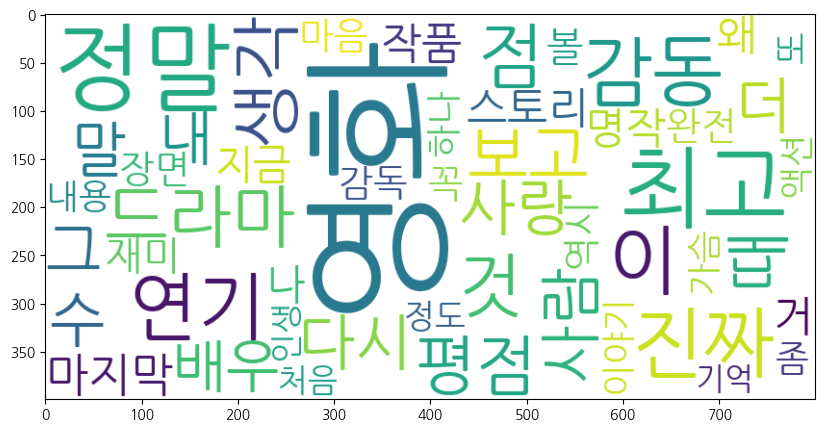

In [ ]:
#워드클라우드_긍정
wordcloud = WordCloud(font_path=font_path,
                      width = 800, height= 400,
                      background_color = 'white').generate_from_frequencies(dict(top_50_positive))

#결과 시각화
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

(참고)
top 50 단어에 대해서 워드클라우드를 생성하였지만, 불용어 처리(예, 자주 등장하는 단어중 긍/부정 의미가 없는 '영화', '정말', '진짜' 등)하고, 단어 수를 늘려서 워드클라우드를 생성한다면, 긍/부정 댓글에 자주 사용된 단어들을 확인할 수 있음

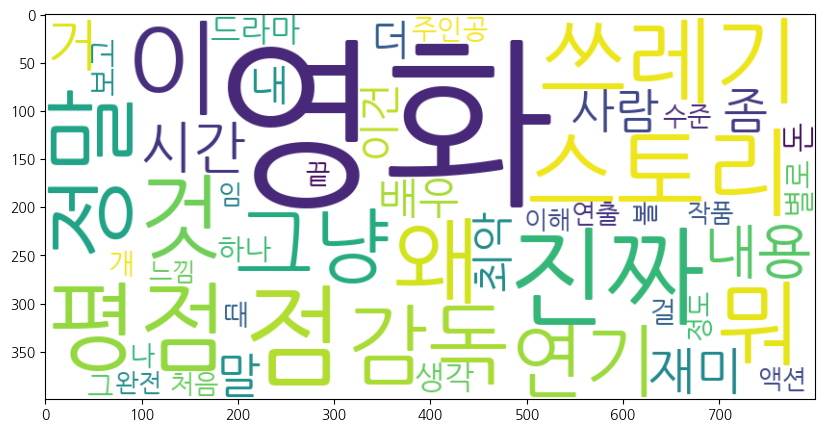

In [ ]:
#워드클라우드_부정
wordcloud = WordCloud(font_path=font_path,
                      width = 800, height= 400,
                      background_color = 'white').generate_from_frequencies(dict(top_50_negative))

#결과 시각화
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [ ]:
dir(WordCloud)
# generate_from_frequencies : 빈도수에 따른 단어 크기를 설정.

['__array__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_generated',
 '_draw_contour',
 '_get_bolean_mask',
 'fit_words',
 'generate',
 'generate_from_frequencies',
 'generate_from_text',
 'process_text',
 'recolor',
 'to_array',
 'to_file',
 'to_image',
 'to_svg']

# 데이터 전처리
- 텍스트 데이터를 신경망에 입력하기 위한 전처리
   - Token(konlpy, nouns()) + 불용어 제거 + (빈도수)
   - Token -> Label
   - pad sequence
   - LSTM

In [ ]:
def tokenize(doc):
  """Tokenizes a Korean document using Okt.

  Args:
    doc: The input document string.

  Returns:
    A list of tokens.
  """
  # Convert the input to string before processing
  return okt.morphs(str(doc))

df['tokens'] = df['document'].apply(tokenize)

## 단계 1. 토큰화


## 단계 2. (옵션) 불용어 제거


## 단계 3. (옵션) 특정 빈도수 이상 등장한 토큰만 남기기


## 단계 4. 토큰을 벡터(숫자)로 변환
- [참고자료 : Embedding Projector](https://projector.tensorflow.org/)


## 단계 5. 글자 수 맞추기(pad_sequnce)

## 단계6. 학습/테스트 데이터셋 분할

# 학습 모델 생성
- LSTM 신경망을 사용하여 긍부정(이진분류)를 판단할 수 있는 분류기 생성

# 평가
- 정확도(acccuracy) 기반 평가